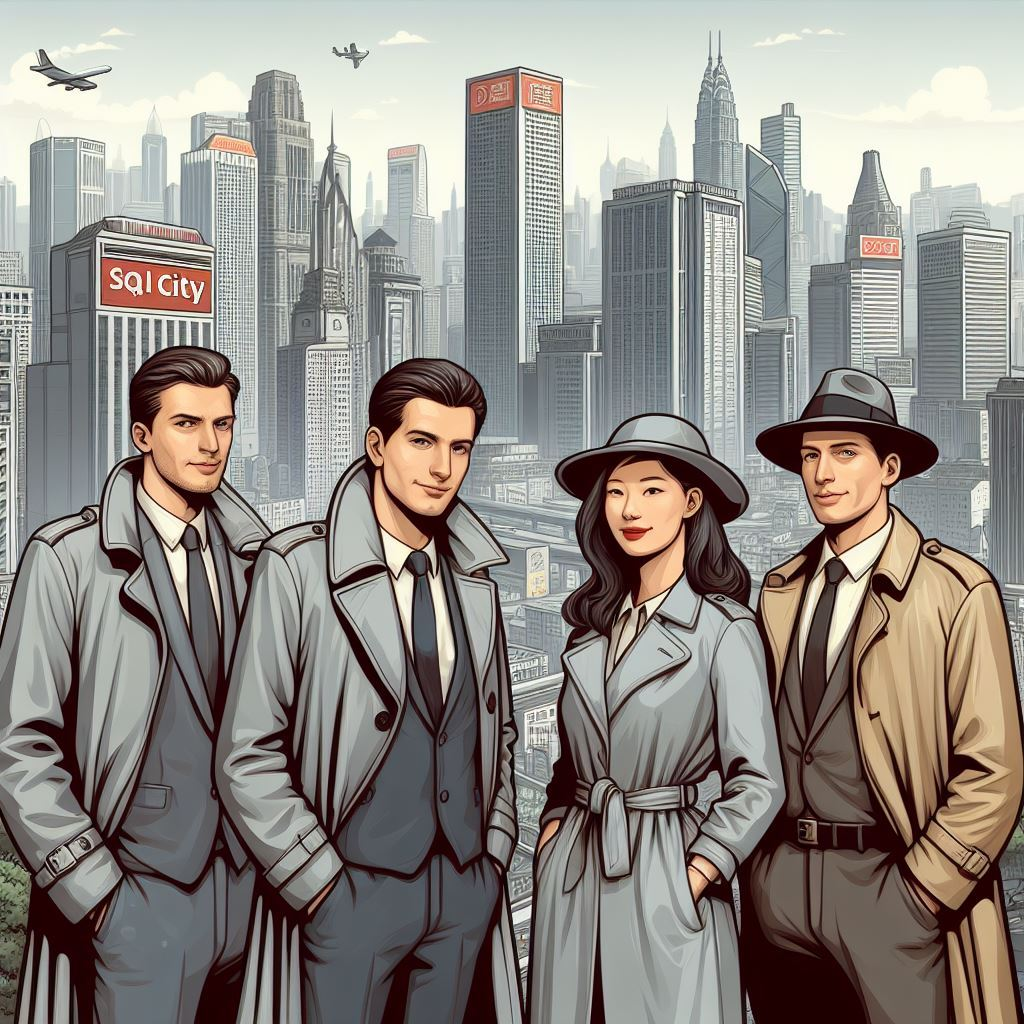

*A crime has taken place and the detective needs your help. The detective gave you the crime scene report, but you somehow lost it. You vaguely remember that the crime was a **murder** that occurred sometime on **Jan.15, 2018** and that it took place in **SQL City**. Start by retrieving the corresponding crime scene report from the police department’s database.*

In [29]:
import sqlite3
import pandas as pd

# permite ver todo el texto de las columnas
pd.set_option('display.max_colwidth', None)


In [11]:
connection = sqlite3.connect("./Data/sql-murder-mystery.db")

# Obtenemos un cursor que utilizaremos para hacer las queries

cursor = connection.cursor()


# Con esta función leemos los datos y lo pasamos a un DataFrame de Pandas
def sql_query(query):

    # Ejecuta la query
    cursor.execute(query)
                                    

    # Almacena los datos de la query 
    ans = cursor.fetchall()

    # Obtenemos los nombres de las columnas de la tabla
    names = [description[0] for description in cursor.description]

    return pd.DataFrame(ans,columns=names)


In [12]:
# query para obtener todas las tablas
query='''
SELECT name 
FROM sqlite_master
where type = "table"
'''
sql_query(query)


,name
0,crime_scene_report
1,drivers_license
2,person
3,facebook_event_checkin
4,interview
5,get_fit_now_member
6,get_fit_now_check_in
7,income
8,solution


In [28]:
# ataco a la tabla de 'crime_scene_report' filtrando por:
# ​murder​ on ​Jan.15, 2018​ in ​SQL City 
query='''
SELECT *
FROM crime_scene_report
WHERE date = ('20180115')
AND type = "murder"
AND city = "SQL City"
'''
sql_query(query)


,date,type,description,city
0,20180115,murder,"Security footage shows that there were 2 witnesses. The first witness lives at the last house on ""Northwestern Dr"". The second witness, named Annabel, lives somewhere on ""Franklin Ave"".",SQL City


In [14]:
# llamada para obtener info del testigo 1 --> ataco a person filtrando por la calle y el último número:
# "lives at the last house on "Northwestern Dr"
query='''
SELECT *
FROM person
WHERE address_street_name = 'Northwestern Dr'
ORDER BY address_number DESC
LIMIT 1;
'''
sql_query(query)

,id,name,license_id,address_number,address_street_name,ssn
0,14887,Morty Schapiro,118009,4919,Northwestern Dr,111564949


In [15]:
# llamada para obtener la info del testigo 2 --> ataco por la calle y nombre. 
query='''
SELECT *
FROM person
WHERE address_street_name = ('Franklin Ave')
AND name LIKE "%Annabel%"
'''
sql_query(query)

,id,name,license_id,address_number,address_street_name,ssn
0,16371,Annabel Miller,490173,103,Franklin Ave,318771143


In [16]:
# la estrategia es acceder a la tabla interview para ver sus declaraciones
# para ello, necesito el 'person_id', que es el mismo que el id en la tabla person'

# interview de Annabel
query='''
SELECT *
FROM interview
WHERE person_id = 16371
'''
sql_query(query)

,person_id,transcript
0,16371,"I saw the murder happen, and I recognized the killer from my gym when I was working out last week on January the 9th."


In [17]:
# interview de Morty
query='''
SELECT *
FROM interview
WHERE person_id = 14887
'''
sql_query(query)

,person_id,transcript
0,14887,"I heard a gunshot and then saw a man run out. He had a ""Get Fit Now Gym"" bag. The membership number on the bag started with ""48Z"". Only gold members have those bags. The man got into a car with a plate that included ""H42W""."


In [18]:
# a partir del relato de Morty:
# busco en la tabla de miembros del gym usuarios que su id empeice por "48Z" que tengan el status "gold"
query='''
SELECT *
FROM get_fit_now_member
WHERE id LIKE '48Z%'
AND membership_status = "gold"
'''
sql_query(query)


,id,person_id,name,membership_start_date,membership_status
0,48Z7A,28819,Joe Germuska,20160305,gold
1,48Z55,67318,Jeremy Bowers,20160101,gold


In [19]:
# ataco a drivers_license flitrando por plate number que contiene 'h42'
query='''
SELECT *
FROM drivers_license
WHERE plate_number LIKE '%H42W%';

'''
sql_query(query)

,id,age,height,eye_color,hair_color,gender,plate_number,car_make,car_model
0,183779,21,65,blue,blonde,female,H42W0X,Toyota,Prius
1,423327,30,70,brown,brown,male,0H42W2,Chevrolet,Spark LS
2,664760,21,71,black,black,male,4H42WR,Nissan,Altima


In [20]:
# ahora llamo a la tabla persons para saber cruzar los sospechosos del gimnasio con los dueños de coches
# a partir de del license_ID:
query='''
SELECT *
FROM person
WHERE license_Id IN (183779, 423327, 664760);
'''
sql_query(query)

,id,name,license_id,address_number,address_street_name,ssn
0,51739,Tushar Chandra,664760,312,Phi St,137882671
1,67318,Jeremy Bowers,423327,530,"Washington Pl, Apt 3A",871539279
2,78193,Maxine Whitely,183779,110,Fisk Rd,137882671


El sospechoso principal es Jeremy Bowers:  
- es hombre
- es miembro gold del gym
- su matrícula contiene los números 'h42'
- su id del gym empieza por '48z'  

Confirmamos en la base de datos y efectivamente nos informa lo siguiente:  
*Congrats, you found the murderer! But wait, there's more...* 
*If you think you're up for a challenge, try querying the interview transcript of the murderer to find the real villain behind this crime.* 
*If you feel especially confident in your SQL skills, try to complete this final step with no more than 2 queries.* 
*Use this same INSERT statement with your new suspect to check your answer.*

Continuamos la investigacion para conseguir la mente maestra.

In [22]:
# hago una llamada para revisar su interview a través de su person_id
query='''
SELECT *
FROM interview
WHERE person_id = 67318;
'''
sql_query(query)

,person_id,transcript
0,67318,"I was hired by a woman with a lot of money. I don't know her name but I know she's around 5'5"" (65"") or 5'7"" (67""). She has red hair and she drives a Tesla Model S. I know that she attended the SQL Symphony Concert 3 times in December 2017.\n"


In [23]:
# busco a la persona que describe en la tabla license_Id:
query='''             
SELECT *
FROM drivers_license
WHERE hair_color = 'red'
  AND height BETWEEN 65 AND 67
  AND car_make = 'Tesla'
  AND gender = 'female';
'''
sql_query(query)


,id,age,height,eye_color,hair_color,gender,plate_number,car_make,car_model
0,202298,68,66,green,red,female,500123,Tesla,Model S
1,291182,65,66,blue,red,female,08CM64,Tesla,Model S
2,918773,48,65,black,red,female,917UU3,Tesla,Model S


In [24]:
# vuelvo a llamar a tabla person para obtener los nombres de las tres sospechosas:
query='''
SELECT *
FROM person
WHERE license_Id IN (202298, 291182,  918773);
'''
sql_query(query)



,id,name,license_id,address_number,address_street_name,ssn
0,78881,Red Korb,918773,107,Camerata Dr,961388910
1,90700,Regina George,291182,332,Maple Ave,337169072
2,99716,Miranda Priestly,202298,1883,Golden Ave,987756388


In [25]:
# Jeremy Bowers también decía que la soscheposa tenía mucho dinero y que había ido tres veces a un concierto, 
# primero compruebo lo del dinero a través del ssn atacando a la tabla income:

query='''
SELECT *
FROM income
WHERE ssn IN (961388910, 337169072,  987756388);
'''
sql_query(query)


,ssn,annual_income
0,961388910,278000
1,987756388,310000


In [26]:
# ahora voy a comprobar si algunas de esas personas fue 3 veces al concierto:
'''
SELECT *
FROM facebook_event_checkin
WHERE person_Id IN (78881, 90700,  99716);
'''
# person_id	    event_id	         event_name	          date
#99716	        1143	             SQL Symphony Concert	20171206
#99716	        1143	             SQL Symphony Concert	20171212
#99716	        1143	             SQL Symphony Concert	20171229


'\nSELECT *\nFROM facebook_event_checkin\nWHERE person_Id IN (78881, 90700,  99716);\n'

La potencial mente maestra es Miranda Priestly:  
- acudió 3 veces al SQL Symphony Concert en diciembre del 2017
- tiene un anual income de 310000  

Comprobamos:  
*Congrats, you found the brains behind the murder! Everyone in SQL City hails you as the greatest SQL detective of all time.* 
*Time to break out the champagne!*